### 모델 성능 향상시키기 

In [57]:
import pandas as pd 
from tensorflow import keras
from keras import Sequential, Input
from keras.layers import Dense 
from sklearn.model_selection import train_test_split

df = pd.read_csv("./wine.csv", header=None)

df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


#### 검증셋 더하기 
- 검증셋 : model.fit() 함수에 <b>validation_split</b> 옵션 주기 

In [58]:
x = df.iloc[:, 0:12]
y = df.iloc[:, 12]

# 학습셋, 데이터셋 나누기 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=True)


#### 모델 구조 

In [59]:
model = Sequential() 
model.add(Input(shape=(12,)))
model.add(Dense(30, activation="relu"))
model.add(Dense(12, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 30)                390       
                                                                 
 dense_21 (Dense)            (None, 12)                372       
                                                                 
 dense_22 (Dense)            (None, 8)                 104       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 875 (3.42 KB)
Trainable params: 875 (3.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 모델 컴파일 

In [60]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

#### 모델 저장하기 

In [61]:
from keras.callbacks import ModelCheckpoint

model_path = "./model/{epoch:02d}-{val_accuracy:4f}.hdf5"

checkpointer = ModelCheckpoint(filepath=model_path, verbose = 1)


#### 모델 실행 

In [62]:
history = model.fit(x_train, y_train, 
                    epochs=2000, 
                    batch_size=500, 
                    validation_split=0.25,
                    verbose = 0)

#### 테스트 결과 출력

In [63]:
score = model.evaluate(x_test, y_test)
print("테스트 정확도 : %.2f%%" %(score[1]*100))

41/41 [==============================] - 0s 333us/step - loss: 0.0756 - accuracy: 0.9869
테스트 정확도 : 98.69%


In [64]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.529101,0.802155,0.341024,0.876154
1,0.363334,0.879138,0.349084,0.893846
2,0.336152,0.877342,0.320953,0.880000
3,0.327786,0.861945,0.315250,0.880000
4,0.316226,0.877598,0.303701,0.897692
...,...,...,...,...
1995,0.021993,0.995381,0.042775,0.989231
1996,0.027325,0.991789,0.052821,0.990000
1997,0.020558,0.994611,0.048335,0.987692
1998,0.021003,0.993841,0.045781,0.990769


In [65]:
# 학습셋 오차 
y_loss = hist_df["loss"]

# 검증셋 오차 
y_vloss = hist_df["val_loss"]

#### 학습셋, 검증셋 오차 비교 그래프 그리기 

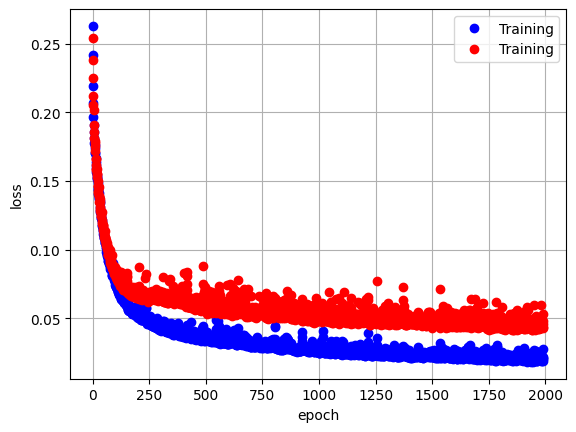

In [66]:
import numpy as np 
import matplotlib.pyplot as plt

x_len = np.arange(len(y_loss)-7)
plt.figure() 
plt.plot(x_len, y_loss[7:], 'o', c="blue", label="Training")
plt.plot(x_len, y_vloss[7:], 'o', c="red", label="Training")
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.show()

-> 학습셋 오차는 줄어들지만 검증셋 오차는 커짐

#### 학습 자동 중단시키기 : EarlyStopping() 

In [67]:
from keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=20)
checkpointer = ModelCheckpoint(filepath=model_path, monitor="val_loss",
                               verbose=0, save_best_only=True)

In [68]:
history = model.fit(x_train, y_train,
                    epochs=2000, batch_size=500,
                    validation_split=0.25, verbose=1,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0192 - accuracy: 0.9956 - val_loss: 0.0436 - val_accuracy: 0.9915
Epoch 2/2000
8/8 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9949 - val_loss: 0.0433 - val_accuracy: 0.9915
Epoch 3/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9946 - val_loss: 0.0445 - val_accuracy: 0.9908
Epoch 4/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0495 - val_accuracy: 0.9877
Epoch 5/2000
8/8 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.0431 - val_accuracy: 0.9900
Epoch 6/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9956 - val_loss: 0.0482 - val_accuracy: 0.9908
Epoch 7/2000
8/8 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 0.9946 - val_loss: 0.0441 - val_accuracy: 0.9908
Epoch 8/2000
8/8 [==

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 3ms/step - loss: 0.0212 - accuracy: 0.9938 - val_loss: 0.0429 - val_accuracy: 0.9900
Epoch 13/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.0444 - val_accuracy: 0.9900
Epoch 14/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9949 - val_loss: 0.0439 - val_accuracy: 0.9915
Epoch 15/2000
8/8 [==============================] - 0s 3ms/step - loss: 0.0190 - accuracy: 0.9951 - val_loss: 0.0422 - val_accuracy: 0.9908
Epoch 16/2000
8/8 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0495 - val_accuracy: 0.9892
Epoch 17/2000
8/8 [==============================] - 0s 4ms/step - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.0413 - val_accuracy: 0.9908
Epoch 18/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.0444 - val_accuracy: 0.9908
Epoch 19/2000
8/8 [========

In [69]:
score = model.evaluate(x_test, y_test)
print("테스트 정확도 : %.2f%%" %(score[1]*100))

41/41 [==============================] - 0s 350us/step - loss: 0.0781 - accuracy: 0.9869
테스트 정확도 : 98.69%
